In [1]:
# I recomputed the features and added in a stochastic momentum indicator
import pandas as pd
import numpy as np

file_path = '/Users/benwong/Documents/Y3S2/dse4211/dse4211 grp project/dataset/raw_data.csv'
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'], format="%d/%m/%y", errors='coerce')
df = df.sort_values(by=['ticker', 'date'])

# Compute Technical Indicators

# SMA (Simple Moving Average)
df['sma_50'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(window=50).mean())

# Volatility (Standard Deviation over 30 Days)
df['volatility_30'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(window=30).std())

# MACD
df['ema_12'] = df.groupby('ticker')['close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
df['ema_26'] = df.groupby('ticker')['close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
df['macd'] = df['ema_12'] - df['ema_26']
df['macd_signal'] = df.groupby('ticker')['macd'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
df['macd_histogram'] = df['macd'] - df['macd_signal']

# Bollinger Bands
df['bollinger_upper'] = df['sma_50'] + (2 * df['volatility_30'])
df['bollinger_lower'] = df['sma_50'] - (2 * df['volatility_30'])
df['bollinger_bandwidth'] = (df['bollinger_upper'] - df['bollinger_lower']) / df['sma_50']

# RSI (Relative Strength Index)
delta = df.groupby('ticker')['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()
rs = avg_gain / avg_loss
df['rsi_14'] = 100 - (100 / (1 + rs))

# ATR (Average True Range)
df['high_low'] = df['high'] - df['low']
df['high_close'] = np.abs(df['high'] - df['close'].shift(1))
df['low_close'] = np.abs(df['low'] - df['close'].shift(1))
df['true_range'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
df['atr_14'] = df.groupby('ticker')['true_range'].transform(lambda x: x.rolling(window=14).mean())

# Momentum (5 Days)
df['momentum_5'] = df.groupby('ticker')['close'].transform(lambda x: x - x.shift(5))

# Volume Moving Average (5 Days)
df['volume_ma_5'] = df.groupby('ticker')['volume'].transform(lambda x: x.rolling(window=5).mean())

# Stochastic %D (14-day %K smoothed with 3-day SMA)
df['lowest_low'] = df.groupby('ticker')['low'].transform(lambda x: x.rolling(window=14).min())
df['highest_high'] = df.groupby('ticker')['high'].transform(lambda x: x.rolling(window=14).max())
df['stoch_k_14'] = 100 * (df['close'] - df['lowest_low']) / (df['highest_high'] - df['lowest_low'])
df['stoch_d_14'] = df.groupby('ticker')['stoch_k_14'].transform(lambda x: x.rolling(window=3).mean())

# Drop intermediate calculation columns
df.drop(columns=['ema_12', 'ema_26', 'high_low', 'high_close', 'low_close', 'true_range', 'lowest_low', 'highest_high', 'stoch_k_14'], inplace=True)

# Save processed dataset
output_file_path = '/Users/benwong/Documents/Y3S2/dse4211/dse4211 grp project/dataset/processed_data.csv'
df.to_csv(output_file_path, index=False)
print(f"Processed data saved to: {output_file_path}")

Processed data saved to: /Users/benwong/Documents/Y3S2/dse4211/dse4211 grp project/dataset/processed_data.csv


In [63]:
#Method 2: LSTM method
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# Load dataset
file_path = '/Users/benwong/Documents/Y3S2/dse4211/dse4211 grp project/dataset/processed_data.csv'
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(subset=["date"], inplace=True)
df.set_index("date", inplace=True)
df.dropna(inplace=True)

# Settings
assets = df["ticker"].unique()
VALIDATION_START = "2024-01-01"
VALIDATION_END = "2024-12-31"
TEST_START = "2025-01-01"
TEST_END = "2025-02-28"
features = ["sma_50", "volatility_30", "macd", "macd_signal", "macd_histogram", "bollinger_upper",
            "bollinger_lower", "bollinger_bandwidth", "rsi_14", "atr_14", "momentum_5",
            "volume_ma_5", "stoch_d_14"]

time_steps = 10
performance = {}
models = {}
scalers = {}
target_scalers = {}

# Helper: Sequence creation
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Train LSTM per asset
for asset in assets:
    df_asset = df[df["ticker"] == asset].copy()
    df_asset["Close_Next_Day"] = df_asset["close"].shift(-1)
    df_asset.dropna(inplace=True)

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_asset[features])
    scalers[asset] = scaler

    target_scaler = StandardScaler()
    scaled_target = target_scaler.fit_transform(df_asset[["Close_Next_Day"]])
    target_scalers[asset] = target_scaler

    df_asset["Close_Next_Day_Scaled"] = scaled_target

    X_all, y_all = create_sequences(scaled_features, df_asset["Close_Next_Day_Scaled"].values, time_steps)
    index = df_asset.index[time_steps:]

    df_seq = pd.DataFrame({'date': index, 'ticker': asset})
    df_seq["scaled_y"] = y_all

    X_train = X_all[df_seq["date"] < TEST_START]
    y_train = y_all[df_seq["date"] < TEST_START]
    X_test = X_all[df_seq["date"] >= TEST_START]
    y_test = y_all[df_seq["date"] >= TEST_START]
    test_dates = df_seq[df_seq["date"] >= TEST_START]["date"].values

    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True, input_shape=(time_steps, len(features)))),
        Dropout(0.2),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)
    models[asset] = model

    if len(X_test) > 0:
        predictions = model.predict(X_test)
        y_pred = target_scaler.inverse_transform(predictions)
        y_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))
        mae = mean_absolute_error(y_actual, y_pred)
        performance[asset] = {"MAE": mae}
        print(f"{asset} MAE: {mae:.2f}")
    else:
        print(f"{asset}: No test data")


Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3271
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1521
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1374
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1258
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1179
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1169
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1148
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1179
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1140
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1136
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0987
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0993
Epoch 13/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0984
Epoch 14/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1079
Epoch 15/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0998
Epoch 16/50
75/75 ━━━━━━━━━━

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2960
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1300
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1186
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1061
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1086
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1072
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0904
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0969
Epoch 9/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0931
Epoch 10/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0885
Epoch 11/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0871
Epoch 12/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0901
Epoch 13/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0846
Epoch 14/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0938
Epoch 15/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0832


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2788
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1398
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1249
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1210
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1157
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1171
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1081
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1058
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0982
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1008
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0962
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0984
Epoch 13/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1003
Epoch 14/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0959
Epoch 15/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0912
Epoch 16/50
75/75 ━━━━━━━━━━━━

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3551
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1375
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1238
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1200
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1119
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1146
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1005
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1055
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1072
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0998
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1006
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1170
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0962
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0997
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1038
Epoch 16/50
63/63 ━━━━━━━━━━━━

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2878
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1405
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1174
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1037
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1059
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1062
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1002
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1040
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0944
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0947
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1055
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0918
Epoch 13/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0884
Epoch 14/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0872
Epoch 15/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0907
Epoch 16/50
75/75 ━━━━━━━━━━━━

In [157]:
# Simulated Trading Strategy
initial_cash = 1_000_000
portfolio = {asset: 0 for asset in assets}
portfolio["cash"] = initial_cash
trade_log = []
highest_price = {asset: 0 for asset in assets}
TRADE_THRESHOLD = 0.5
TRAILING_STOP_LOSS = -1
portfolio_values = []

for date in pd.date_range(TEST_START, TEST_END):
    predicted_prices_today = {}
    expected_returns_today = {}

    # Prepare predicted prices and expected returns
    for asset in assets:
        df_asset = df[df["ticker"] == asset]
        if len(df_asset.loc[:date]) < time_steps:
            continue

        recent_data = df_asset.loc[:date].tail(time_steps)
        actual_price = recent_data.iloc[-1]["close"]

        X = scalers[asset].transform(recent_data[features])
        X_input = X.reshape(1, time_steps, len(features))
        pred_scaled = models[asset].predict(X_input)[0][0]
        predicted_price = target_scalers[asset].inverse_transform([[pred_scaled]])[0][0]

        expected_return = ((predicted_price - actual_price) / actual_price) * 100

        predicted_prices_today[asset] = predicted_price
        expected_returns_today[asset] = expected_return

    # SELL logic
    for asset in assets:
        if portfolio[asset] == 0:
            continue

        df_asset = df[df["ticker"] == asset]
        if date not in df_asset.index:
            continue

        actual_price = df_asset.loc[date, "close"]
        current_er = expected_returns_today.get(asset)
        if current_er is None:
            continue

        if actual_price > highest_price[asset]:
            highest_price[asset] = actual_price

        # Look for better asset to switch into
        for other_asset, other_er in expected_returns_today.items():
            if other_asset == asset or portfolio[other_asset] > 0:
                continue

            if other_er > current_er and other_er > TRADE_THRESHOLD:
                quantity = portfolio[asset]
                sell_fee = round(max(0.005*quantity, 1.0),2)
                portfolio["cash"] += quantity * actual_price - sell_fee
                portfolio[asset] = 0
                trade_log.append((date, "SELL", asset, quantity, actual_price, sell_fee))
                print(f"{date.date()}: SELL {quantity:.6f} {asset} at ${actual_price:.2f} (Switch to better asset: {other_asset})")

                # Immediately BUY the better asset
                df_other = df[df["ticker"] == other_asset]
                if date in df_other.index:
                    other_price = df_other.loc[date, "close"]
                else:
                    df_other = df_other[df_other.index <= date]
                    if df_other.empty:
                        break
                    other_price = df_other.iloc[-1]["close"]
                #i set to 98% of the portfolio to leave space for the transaction fees & setting shares bought to IBKR 6dp
                buy_qty =round(0.98 * portfolio["cash"] / other_price, 6)
                if buy_qty > 0:
                    portfolio[other_asset] += buy_qty
                    buy_fee = round(max(buy_qty * 0.005, 1.0), 2)
                    portfolio["cash"] -= buy_qty * other_price + buy_fee
                    highest_price[other_asset] = other_price
                    trade_log.append((date, "BUY", other_asset, buy_qty, other_price, buy_fee))
                    print(f"{date.date()}: BUY {buy_qty:.6f} {other_asset} at ${other_price:.2f} (Post-switch Expected Return: {other_er:.2f}%)")
                break

        # Trailing stop logic
        price_drop = ((actual_price - highest_price[asset]) / highest_price[asset]) * 100
        if price_drop < TRAILING_STOP_LOSS:
            quantity = portfolio[asset]
            sell_fee = round(max(0.005*quantity, 1.0),2)
            portfolio["cash"] += quantity * actual_price - sell_fee
            portfolio[asset] = 0
            trade_log.append((date, "SELL", asset, quantity, actual_price, sell_fee))
            print(f"{date.date()}: SELL {quantity:.6f} {asset} at ${actual_price:.2f} (Trailing Stop Triggered)")

    # BUY logic
    buy_candidates = []
    for asset, expected_return in expected_returns_today.items():
        df_asset = df[df["ticker"] == asset]
        if date not in df_asset.index:
            continue
        actual_price = df_asset.loc[date, "close"]
        if expected_return > TRADE_THRESHOLD and portfolio["cash"] > actual_price and portfolio[asset] == 0:
            buy_candidates.append((expected_return, asset, actual_price))

    buy_candidates.sort(reverse=True, key=lambda x: x[0])
    for expected_return, asset, actual_price in buy_candidates:
        if portfolio["cash"] < actual_price:
            break
        quantity = round(0.98 * portfolio["cash"] / actual_price, 6)
        portfolio[asset] += quantity
        buy_fee = round(max(quantity * 0.005, 1.0), 2)
        portfolio["cash"] -= quantity * actual_price + buy_fee
        highest_price[asset] = actual_price
        trade_log.append((date, "BUY", asset, quantity, actual_price, buy_fee))
        print(f"{date.date()}: BUY {quantity:.6f} {asset} at ${actual_price:.2f} (Expected Return: {expected_return:.2f}%)")

    # Track portfolio value
    daily_value = portfolio["cash"]
    for asset in assets:
        df_asset = df[df["ticker"] == asset]
        if date in df_asset.index:
            price = df_asset.loc[date, "close"]
        else:
            df_asset = df_asset[df_asset.index <= date]
            if df_asset.empty:
                continue
            price = df_asset.iloc[-1]["close"]
        daily_value += portfolio[asset] * price
    portfolio_values.append((date, daily_value))

# Final Portfolio Summary
final_date = portfolio_values[-1][0]
final_value = portfolio["cash"]

for asset in assets:
    df_asset = df[df["ticker"] == asset]
    if final_date in df_asset.index:
        latest_price = df_asset.loc[final_date, "close"]
    else:
        df_asset = df_asset[df_asset.index <= final_date]
        if df_asset.empty:
            continue
        latest_price = df_asset.iloc[-1]["close"]

    asset_value = portfolio[asset] * latest_price
    final_value += asset_value
    print(f"{asset} Holdings: {portfolio[asset]:.6f} x ${latest_price:.2f} = ${asset_value:.2f}")

roi = (final_value - initial_cash) / initial_cash * 100
print(f"\nFinal Portfolio Value: ${final_value:.2f}")
print(f"ROI: {roi:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2025-01-03: BUY 4024.805856 GLD at $243.49 (Expected Return: 1.15%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

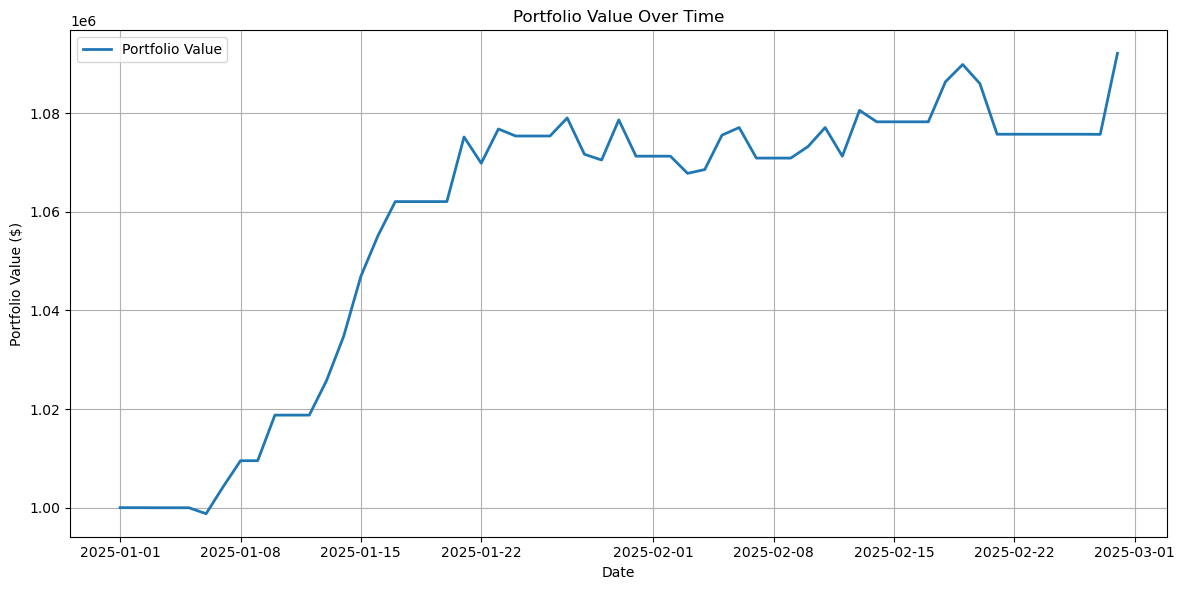

In [159]:
# Plot of portfolio value change over time
import matplotlib.pyplot as plt
portfolio_df = pd.DataFrame(portfolio_values, columns=["date", "portfolio_value"])
portfolio_df.set_index("date", inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df.index, portfolio_df["portfolio_value"], label="Portfolio Value", linewidth=2)
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
# Expected Value Changes Over Time for visualisation // can ignore i was just trying to visualise how it works
for date in pd.date_range(TEST_START, TEST_END):
    print(f"\n=== {date.date()} ===")  # <-- Add this line

    buy_candidates = []

    for asset in assets:
        df_asset = df[df["ticker"] == asset]
        if len(df_asset.loc[:date]) < time_steps:
            continue

        recent_data = df_asset.loc[:date].tail(time_steps)
        actual_price = recent_data.iloc[-1]["close"]

        X = scalers[asset].transform(recent_data[features])
        X_input = X.reshape(1, time_steps, len(features))
        pred_scaled = models[asset].predict(X_input)[0][0]
        predicted_price = target_scalers[asset].inverse_transform([[pred_scaled]])[0][0]

        expected_return = ((predicted_price - actual_price) / actual_price) * 100

        #PRINT EXPECTED RETURN FOR ALL ASSETS
        print(f"{asset} | Actual: ${actual_price:.2f} | Predicted: ${predicted_price:.2f} | Expected Return: {expected_return:.2f}%")

        if expected_return > TRADE_THRESHOLD and portfolio["cash"] > actual_price:
            buy_candidates.append((expected_return, asset, actual_price, predicted_price))


=== 2025-01-01 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
BND | Actual: $71.46 | Predicted: $70.90 | Expected Return: -0.79%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
BTC-USD | Actual: $94419.76 | Predicted: $88610.22 | Expected Return: -6.15%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
GLD | Actual: $242.13 | Predicted: $241.59 | Expected Return: -0.23%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
QQQM | Actual: $210.45 | Predicted: $210.24 | Expected Return: -0.10%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
SCHV | Actual: $26.07 | Predicted: $26.00 | Expected Return: -0.28%

=== 2025-01-02 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
BND | Actual: $71.49 | Predicted: $70.86 | Expected Return: -0.89%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
BTC-USD | Actual: $96886.88 | Predicted: $87278.29 | Expected Return: -9.92%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
GLD | Actual: $245.42 | Predicted: $241.49 | Expected Return: -1.60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
QQQM | Actual: $210.05 | Predicted: $208.75 | Expected

[*********************100%***********************]  1 of 1 completed


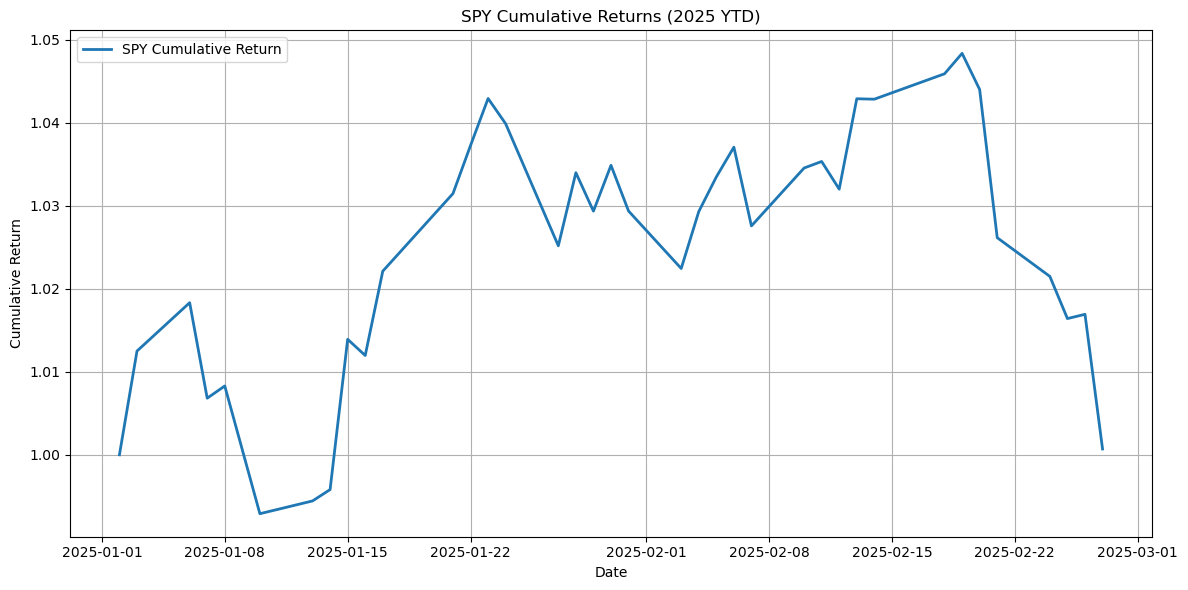

Pct Change of SPY YTD is 0.07012%.


In [127]:
# Comparison to benchmark returns for SPY
import yfinance as yf
spy_data = yf.download("SPY" , start = "2025-01-01", end = "2025-02-28", auto_adjust = True) #can amend the start and end date accordingly
#Plot daily cumulative returns of SPY until now
spy_data['Daily_return'] = (spy_data['Close'].pct_change()).fillna(0)
spy_data["cumulative_return"] = (1 + spy_data["Daily_return"]).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(spy_data.index, spy_data["cumulative_return"], label="SPY Cumulative Return", linewidth=2)
plt.title("SPY Cumulative Returns (2025 YTD)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Pct Change of SPY YTD is " + str(round((spy_data["cumulative_return"].iloc[-1] - 1) * 100, 5)) + "%.")

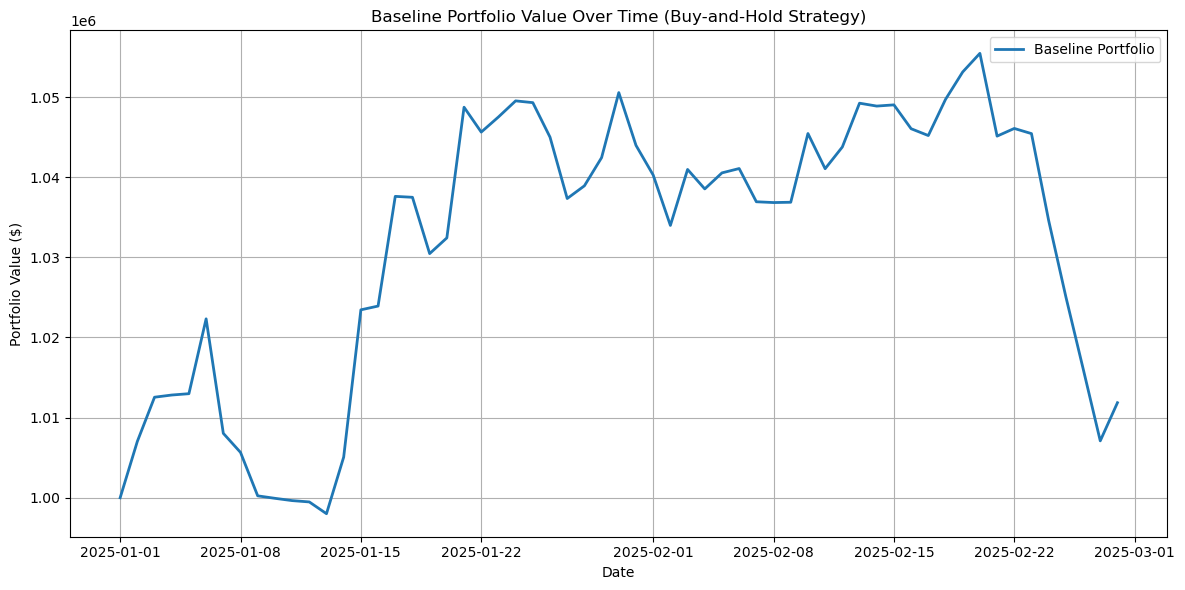

In [123]:
# Comparison with a simple buy and hold strategy with the 5 selected assets across the same period
# Filter for the test period
# Define test period and assets
TEST_START = "2025-01-01"
TEST_END = "2025-02-28"
assets = df["ticker"].unique()
initial_cash = 1_000_000
allocation = initial_cash / len(assets)

# Initialize baseline portfolio
baseline_portfolio_values = []
baseline_holdings = {asset: 0 for asset in assets}
cash_remaining = {asset: allocation for asset in assets}
date_range = pd.date_range(TEST_START, TEST_END)

# Track total portfolio value
for date in date_range:
    total_value = 0
    for asset in assets:
        df_asset = df[df["ticker"] == asset]
        df_asset = df_asset[df_asset.index <= date]
        if df_asset.empty:
            total_value += cash_remaining[asset]
            continue

        if baseline_holdings[asset] == 0:
            price = df_asset.iloc[-1]["close"]
            quantity = cash_remaining[asset] / price
            baseline_holdings[asset] = quantity
            cash_remaining[asset] = 0

        price = df_asset.iloc[-1]["close"]
        total_value += baseline_holdings[asset] * price

    baseline_portfolio_values.append((date, total_value))

# Plot baseline portfolio value
baseline_df = pd.DataFrame(baseline_portfolio_values, columns=["date", "portfolio_value"])
baseline_df.set_index("date", inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(baseline_df.index, baseline_df["portfolio_value"], label="Baseline Portfolio", linewidth=2)
plt.title("Baseline Portfolio Value Over Time (Buy-and-Hold Strategy)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [167]:
from sklearn.linear_model import LinearRegression
# Prep
portfolio_df = portfolio_df.copy()
portfolio_df['returns'] = portfolio_df['portfolio_value'].pct_change().fillna(0)
portfolio_df['cumulative'] = (1 + portfolio_df['returns']).cumprod()

# Special case for beta to make it aligned // removal of additional data for our portfolio that has emerged due to 24/7 trading of crypto 
# more advisable compared to forward filling
spy_returns = spy_data[["Daily_return"]].copy()
portfolio_returns = portfolio_df[["returns"]].copy()

# Inner join on common dates
combined_df = pd.concat([portfolio_returns, spy_returns], axis=1, join='inner')
combined_df.columns = ['portfolio_returns', 'spy_returns']

# Max Drawdown
def max_drawdown(cumulative_returns):
    roll_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / roll_max - 1
    return drawdown.min()

# Sharpe Ratio (Assuming risk-free rate = 0)
def sharpe_ratio(returns, risk_free_rate_annual=0.0435, periods_per_year=252):
    daily_rf = risk_free_rate_annual / periods_per_year
    excess_returns = returns - daily_rf
    return (excess_returns.mean() / returns.std()) * np.sqrt(periods_per_year)
    
# Annualized Volatility
def annualized_volatility(returns, periods_per_year=252):
    return returns.std() * np.sqrt(periods_per_year)

# Beta
def calculate_beta(portfolio_returns, market_returns):
    X = market_returns.values.reshape(-1, 1)
    y = portfolio_returns.values
    reg = LinearRegression().fit(X, y)
    return reg.coef_[0]

# Portfolio metrics
portfolio_max_dd = max_drawdown(portfolio_df['cumulative'])
portfolio_sharpe = sharpe_ratio(portfolio_df['returns'])
portfolio_vol = annualized_volatility(portfolio_df['returns'])
portfolio_beta = calculate_beta(combined_df['portfolio_returns'], combined_df['spy_returns'])

# SPY metrics
spy_max_dd = max_drawdown(spy_data['cumulative_return'])
spy_sharpe = sharpe_ratio(spy_data['Daily_return'])
spy_vol = annualized_volatility(spy_data['Daily_return'])
spy_beta = 1.0  # Benchmark

# Output
print("PORTFOLIO METRICS")
print(f"Max Drawdown: {portfolio_max_dd:.2%}")
print(f"Sharpe Ratio: {portfolio_sharpe:.4f}")
print(f"Annualized Volatility: {portfolio_vol:.2%}")
print(f"Beta: {portfolio_beta:.4f}")
print("\nSPY METRICS")
print(f"Max Drawdown: {spy_max_dd:.2%}")
print(f"Sharpe Ratio: {spy_sharpe:.4f}")
print(f"Annualized Volatility: {spy_vol:.2%}")
print(f"Beta: {spy_beta:.4f}")

PORTFOLIO METRICS
Max Drawdown: -1.30%
Sharpe Ratio: 4.3435
Annualized Volatility: 7.74%
Beta: 0.2505

SPY METRICS
Max Drawdown: -4.55%
Sharpe Ratio: -0.2347
Annualized Volatility: 13.03%
Beta: 1.0000
